# Classifying Data

## Classification via MODIS data

### Importing Packages

In [12]:
import geemap
import numpy as np
import pandas as pd
import ee
from geemap import chart
import matplotlib.pyplot as plt

In [5]:
Map = geemap.Map()
admin = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")
maharashtra = admin.filter(ee.Filter.eq('ADM2_NAME', 'Thane'))

geometry = maharashtra.geometry()

point = ee.Geometry.Point([80.3288, 23.5121])

image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
.filterDate('2019-01-01', '2019-12-31' ) \
.sort('CLOUD_COVER') \
.min() \
.select('B[1-7]') \
.clip(geometry)


vis_params = {
'min': 0,
'max': 3000,
'bands': ['B5', 'B4', 'B3']
}

Map.centerObject(point, 5)
Map.addLayer(image, vis_params, "Landsat-8")
modis = ee.ImageCollection('MODIS/006/MCD12Q1') \
.filterDate('2016-01-01', '2019-01-01') \
.select('LC_Type1') \
.reduce(ee.Reducer.median())

points = modis.sample(**{
'region': ee.Geometry.Rectangle([72.0000, 23.0000, 82.0000, 15.0000]),
'scale': 30,
'numPixels': 5000,
'seed': 0,
'geometries': True  # Set this to False to ignore geometries
})

Map.addLayer(points, {}, 'training', False)

# Use these bands for prediction.
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']


# This property of the table stores the land cover labels.
label = 'LC_Type1_median'
input = image.select(bands)

# Overlay the points on the imagery to get training.
training = input.sampleRegions(**{
'collection': points,
'properties': [label],
'scale': 30
})

# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

result = image.select(bands).classify(trained)

landcover = ee.ImageCollection('MODIS/006/MCD12Q1') \
.filterDate('2019-01-01', '2019-12-31') \
.select('LC_Type1') \
.reduce(ee.Reducer.mean()) \
.clip(geometry)

LandCoverVis = {
'min': 1.0,
'max': 17.0,
'palette': [
'05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
'69fff8', 'f9ffa4', '1c0dff'
],
}

Map.centerObject(point, 5)
Map.addLayer(landcover, LandCoverVis, 'MODIS Land Cover')

# landsatcover = result.set('classification_class_values', [0, 5,13,16])
# landsatcover = landsatcover.set('classification_class_palette', ['1c0dff',  '009900', 'a5a5a5',  'f9ffa4'])
# Map.addLayer(landsatcover, {}, 'Land cover')

ee_class_table = """

Value	Color	Description
0	1c0dff	Water
5	009900	Mixed forest
13	a5a5a5	Urban and built-up
16	f9ffa4	Barren or sparsely vegetated

"""

legend_dict = geemap.legend_from_ee(ee_class_table)
Map.add_legend(legend_title="Land Cover Legend", legend_dict=legend_dict, position='bottomleft')

admin2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2");
maha = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Thane'))

styleParams = {
"fillColor": '#00000000',
"color": '#301934',
"width": 2.0,
}

Map.addLayer(maha.style(**styleParams), {}, 'Maharashtra Districts')
print("Map Generated")



Map Generated


In [21]:
Map.centerObject(thane, 9)
Map

Map(bottom=14898.0, center=[19.602852050969535, 73.16269463943992], controls=(WidgetControl(options=['position…

## Classification via manual feature selection

In [9]:
Map2=geemap.Map()

admin2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")
thane = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Thane'))
s2 = ee.ImageCollection("COPERNICUS/S2")

rgbVis = {
  'min': 0.0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}

# Write a function for Cloud masking
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask).select("B.*").copyProperties(image, ["system:time_start"])

filtered = s2 \
  .filter(ee.Filter.date('2019-01-01', '2019-12-31')) .filter(ee.Filter.bounds(thane)) \
  .map(maskS2clouds).median().clip(thane)

bands = ['B4','B3','B2','B1']
Map2.addLayer(filtered,rgbVis,'Thane')

merged = ee.FeatureCollection("users/jainhn/merged")
# veg.merge(land).merge(water).merge(urban)
sampled= filtered.sampleRegions(collection=merged, properties=['lc'], scale=10)
random_column=sampled.randomColumn()
training_sample=random_column.filter(ee.Filter.gte('random',0.3))
testing_sample=random_column.filter(ee.Filter.lte('random',0.3))

classifier = ee.Classifier.smileRandomForest(50).train(features=training_sample, classProperty='lc', inputProperties=bands)
classified=filtered.classify(classifier)
Map2.addLayer(classified,{'min':0, 'max':3, 'palette':['green','yellow','blue','white']},'Classified image')



legend_keys = ['Vegetation', 'Land', 'Water', 'Urban']
legend_colors = ['#008000', '#FFFF00', '#0000FF', '#FFFFFF']
# legend_colors = ['green','yellow','blue','white']


Map2.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomleft')



<class 'ee.image.Image'>


In [10]:
Map2

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Accuracy classification 

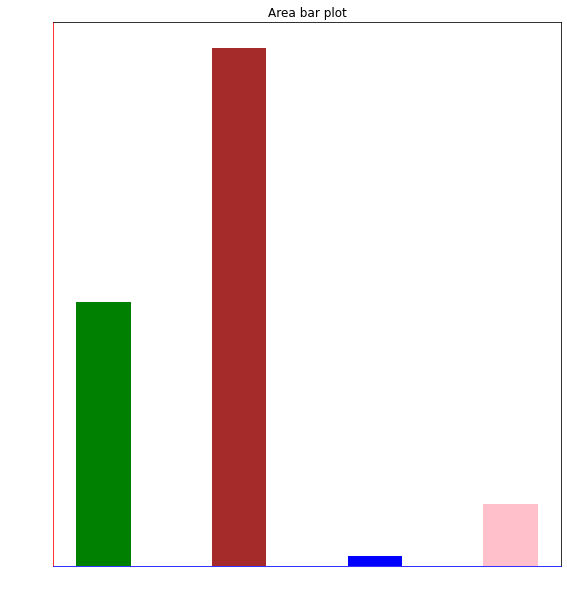

<Figure size 160x320 with 0 Axes>

In [16]:

areaImage = ee.Image.pixelArea().divide(1e6).addBands(classified)

# Calculate Area by Class
# Using a Grouped Reducer
areas = areaImage.reduceRegion(
      reducer= ee.Reducer.sum().group(
      groupField= 1,
      groupName= 'classification'
    ),
    geometry= thane,
    scale= 100,
    tileScale= 4,
    maxPixels= 1e10)


classAreas = ee.List(areas.get('groups'))


# creating the dataset

classes = classAreas.getInfo()
sum_values = [item['sum'] for item in classes]

types = ['Vegetation', 'Land', 'Water', 'Urban']

fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot

ax = fig.add_subplot(121)
ax.bar(types, sum_values, color =['green','brown','blue','pink'],
        width = 0.4)
ax.set_xlabel("Claasiification type")
ax.set_ylabel("Areas of land types")
plt.title("Area bar plot")
plt.figure(figsize=(2, 4), dpi=80)
ax.spines['left'].set_color('red')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('blue')     # setting up X-axis tick color to blue
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plot =plt.show()
plot

In [17]:
train_accuracy = trained.confusionMatrix()
train_accuracy.getInfo()
testing_accuracy=testing_sample.classify(classifier).errorMatrix('lc','classification')
cm=testing_accuracy.getInfo()
cm

[[8, 0, 0, 0], [1, 6, 0, 0], [0, 0, 3, 0], [0, 0, 0, 8]]